In [ ]:
![ ! -f "pip_installed" ] && pip install -q tensorflow-datasets==4.4.0
!touch pip_installed

In [ ]:
![ ! -d "/root/tensorflow_datasets" ] &&  unzip -qq /content/drive/MyDrive/TeamSemiSuperCV/Wing/xray_remix.zip -d /root/tensorflow_datasets
# ![ ! -d "/root/tensorflow_datasets" ] &&  unzip -qq /content/drive/MyDrive/TeamSemiSuperCV/Wing/xray_reborn.zip -d /root/tensorflow_datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from importlib import reload
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, GlobalMaxPooling2D, Lambda
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Model

In [ ]:
IMG_SIZE = (256, 256, 3)

In [ ]:
def img_preprocess(imgs):
    imgs = tf.image.resize(imgs, IMG_SIZE[:2], method='bilinear')
    imgs = tf.cast(imgs, tf.uint8)
    return imgs

def model_preprocess(x):
    x = Rescaling(1/255)(x)
    return x

def make_model(input_shape):
    base_model = ResNet50(include_top=False, pooling=None, weights=None,
                          input_shape=input_shape)
    
    inputs = Input(shape=input_shape)
    x = model_preprocess(inputs)
    x = base_model(x)
    x = Lambda(lambda x: x, name='lambda_1')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = make_model(IMG_SIZE)
model.build(IMG_SIZE)
model.load_weights('/content/drive/MyDrive/TeamSemiSuperCV/Wing/FSL_Benchmarks/FSL_ResNet50_XrayRemix.h5')
model.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 lambda_1 (Lambda)           (None, 8, 8, 2048)        0         
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
model_d = Model(inputs=model.input, outputs=model.layers[-4].output)
model_d.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 lambda_1 (Lambda)           (None, 8, 8, 2048)        0         
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                           

In [ ]:
ds = tfds.load('xray_remix')
ds_train = ds['train']
ds_valid = ds['validation']
ds_test = ds['test']

In [ ]:
ds_train_xy = ds_train.map(lambda d: (d['image'], d['label']))
ds_train_xy = ds_train_xy.map(lambda x, y: (img_preprocess(x), y))
ds_train_xy.element_spec

(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
feats = []
labels = []
for batch_x, batch_y in ds_train_xy.batch(512):
  print(batch_x.shape, batch_y.shape)
  feats.append(model_d(batch_x, training=False))
  labels.append(batch_y)

(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(512, 256, 256, 3) (512,)
(101, 256, 256, 3) (101,)


In [ ]:
feats = np.concatenate(feats)
labels = np.concatenate(labels)
feats.shape, labels.shape

((4709, 64), (4709,))

In [ ]:
npz_file = '/content/drive/MyDrive/TeamSemiSuperCV/Wing/FSL_Benchmarks/FSL_ResNet50_XrayRemix_Feats.npz'
np.savez(npz_file, feats=feats, labels=labels)

In [ ]:
npz = np.load(npz_file)
npz['feats'].shape, npz['labels'].shape

((4709, 64), (4709,))

In [ ]:
npz['feats'][0]

array([2.4017837 , 0.        , 0.        , 0.        , 2.4170513 ,
       0.        , 0.        , 0.        , 2.7228842 , 3.1175122 ,
       1.8136047 , 0.        , 2.2815256 , 2.469659  , 2.4685247 ,
       0.        , 0.        , 0.        , 1.8989674 , 0.        ,
       2.940175  , 0.        , 0.        , 0.        , 3.3693464 ,
       2.0837808 , 3.6419716 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 2.025196  , 0.        ,
       0.        , 4.2839036 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.4485183 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.1054622 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.24951418, 0.        , 0.        , 0.        ,
       2.4928255 , 0.        , 3.1274517 , 0.        ], dtype=float32)

In [ ]:
npz['labels'][:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0])

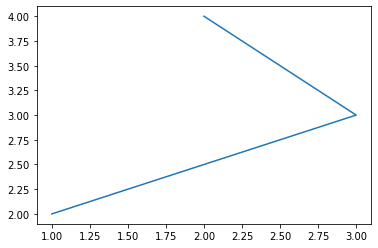

In [38]:
plt.plot([1,3,2],[2,3,4])

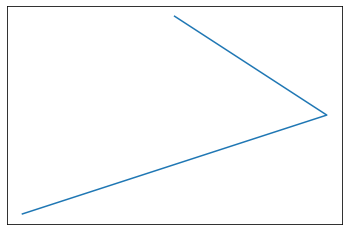

In [51]:
plt.plot([1,3,2],[2,3,4])
plt.tick_params(axis='both', which='both', bottom=False, left=False,
                labelbottom=False, labelleft=False)
plt.show()